In [104]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
##===== Read in Data =====##
data_df = pd.read_hdf('./data/jumping_data_102220.h5')
nTrials = len(data_df)
data_df.head()

In [101]:
#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8

#Loop over trials and reformat data for ARHMM
data_list = []; mask_list = []
for iTrial in range(nTrials):
    #Get coordinates of Take-Off platform
    xc = np.nanmean(data_df.loc[iTrial]['Side TakeFL x'])
    yc = np.nanmean(data_df.loc[iTrial]['Side TakeFL y'])
    
    xy_list = []; ll_list = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        x = data_df.loc[iTrial]['Side {} x'.format(ptstr)]
        y = data_df.loc[iTrial]['Side {} y'.format(ptstr)]
        llhood = data_df.loc[iTrial]['Side {} likelihood'.format(ptstr)]
        
        #Coordinates relative to take-off platform
        xy_list.append((x-xc,y-yc))
        
        #Create mask for points that have a confidence lower than the given threshold
        mask = llhood > confidence_threshold
        ll_list.append((mask,mask))
    
    tmp = np.vstack(xy_list).T; data_list.append(tmp[2:-2,:])
    tmp = np.vstack(ll_list).T; mask_list.append(tmp[2:-2,:])



In [ ]:
BaseDir = './results/ARHMM/Side_NEE-all_mice-2020-10-24_1310/'
kDirs = sorted(os.listdir(BaseDir))[1:-1]

ll_heldout = np.zeros((len(kDirs),6))
ll_training = np.zeros((len(kDirs),6))
Ks = np.arange(4,25,2).tolist()

for ii, kd in enumerate(kDirs):
    print('\n{}:'.format(kd),end='\t')
    
    #Load log-likelihood results for full fit
    fpath = glob(os.path.join(BaseDir,kd,'fit_parameters*.h5'))[0]
    data = ioh5.load(fpath)
    
    #Get K and directory to of kfolds
    K = int(kd[-2:])
    KDir = os.path.join(BaseDir,kd)
    
    ll_heldout[ii,-1] = data['ll_heldout_perstep']
    ll_training[ii,-1] = data['ll_training_perstep']
    
#     #Load MAP sequence results
#     fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
#     trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)
#     opt['MAP_threshold'] = 0.75
#     trMasks2 = []
#     for post in trPosteriors:
#         max_prob = np.max(post,axis=1)
#         trMasks2.append(max_prob > opt['MAP_threshold'])
    
#     #Create temporary ARHMM for plotting functions 
#     arhmm = ssm.HMM(K, 6, observations='autoregressive',transitions='standard')
#     arhmm.init_state_distn.params = arhmm_params['init_state_distn']['P0']
#     arhmm.transitions.params = arhmm_params['transitions']['log_Ps']
#     arhmm.observations.As = arhmm_params['observations']['As']
#     arhmm.observations.bs = arhmm_params['observations']['bs']
          
#     ## Calculate & plot state duration and state usage 
#     state_duration_list, state_startend_list, state_usage = util.get_state_durations(trMAPs, trMasks2, K)
#     usrplt.plot_state_durations2(state_duration_list,state_usage, K,
#                             SAVEFIG=True,PlotDir=KDir,fname='state-durations_ARHMM-{}.pdf'.format(kd))

#     ## Plot example trajectories of actual trajectories for each state
#     usrplt.plot_example_trajectories(state_duration_list,state_startend_list,data_list, arhmm,
#                                     SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_ARHMM-{}.pdf'.format(kd))

#     ## Plot example trajectories simulated from the model for each state
#     usrplt.plot_example_trajectories(state_duration_list,state_startend_list,data_list, arhmm, simulated=True,
#                                     SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_simulated_ARHMM-{}.pdf'.format(kd))
    
#     usrplt.plot_example_state_sequences(trMAPs, trMasks2, data_list, K,
#                                 SAVEFIG=True,PlotDir=KDir,fname='state-sequences_ARHMM-{}.pdf'.format(kd))
    
#     ioh5.save(os.path.join(KDir, 'MAP_seqs-ARHMM-{}.h5'.format(kd)), 
#       {'trMAPs':trMAPs, 'trPosteriors':trPosteriors,'trMasks':trMasks2, 
#        'arhmm_params' : arhmm_params,'state_usage':state_usage, 
#        'hyperparams' : opt})
    
    kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
#     pdb.set_trace()
    for jj,kfold in enumerate(kfold_dirs):
        fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)
    
        ll_heldout[ii,jj] = data['ll_heldout_perstep']
        ll_training[ii,jj] = data['ll_training_perstep']

In [ ]:
BaseDir = './results/ARHMM/Side_NEE-all_mice-2020-10-25_0940/'
kDirs = sorted(os.listdir(BaseDir))[1:]

ll_heldout_recurrent = np.zeros((len(kDirs),6)); ll_heldout_recurrent[:] = np.nan
ll_training_recurrent = np.zeros((len(kDirs),6))
Ks_recurrent = []
kDirs

In [ ]:
for ii, kd in enumerate(kDirs):
    print('\n{}:'.format(kd),end='\t')
    
#     #Load log-likelihood results for full fit
#     fpath = glob(os.path.join(BaseDir,kd,'fit_parameters*.h5'))[0]
#     data = ioh5.load(fpath)
    
    #Get K and directory to of kfolds
    K = int(kd[-2:]); Ks_recurrent.append(K)
    KDir = os.path.join(BaseDir,kd)
    
#     ll_heldout_recurrent[ii,-1] = data['ll_heldout_perstep']
#     ll_training_recurrent[ii,-1] = data['ll_training_perstep']
       
    kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
#     pdb.set_trace()
    for jj,kfold in enumerate(kfold_dirs):
        fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)
    
        ll_heldout_recurrent[ii,jj] = data['ll_heldout_perstep']
        ll_training_recurrent[ii,jj] = data['ll_training_perstep']

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# ax.plot(Ks, np.mean(ll_training[:,:-1], axis=1), 'x-',color=usrplt.cc[0], markersize=8,label='Mean across training kfolds, ARHMM')
ax.plot(Ks, np.mean(ll_heldout[:,:-1], axis=1), 'x-',color=usrplt.cc[0], markersize=8,label='Mean across heldout kfolds, ARHMM ') 

# ax.plot(Ks_recurrent, np.mean(ll_training_recurrent[:,:-1], axis=1), 'o-',color=usrplt.cc[0], markersize=8,label='Mean across training kfolds, recurrent-ARHMM')
ax.plot(Ks_recurrent, np.nanmean(ll_heldout_recurrent[:,:-1], axis=1), 'o-',color=usrplt.cc[1], markersize=8,label='Mean across heldout kfolds, recurrent-ARHMM ')    
ax.set_ylabel('log-likelihood per time-step')
ax.set_xlabel('# HMM states (K)')
ax.set_xticks(Ks)
ax.legend()

ax.set_title('Cross-Validated Log-Likelihood')
plt.savefig('./plots/ARHMM_xvalidation.png')

In [ ]:
np.diff(np.mean(ll_training[:,:-1], axis=1))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# ax.plot(Ks[1:], np.diff(np.mean(ll_training[:,:-1], axis=1)), 'x-',color=usrplt.cc[0], markersize=8,label='Mean across training kfolds, ARHMM')
ax.plot(Ks[1:], np.diff(np.mean(ll_heldout[:,:-1], axis=1)), 'x-',color=usrplt.cc[0], markersize=8,label='Mean across heldout kfolds, ARHMM ') 

# ax.plot(Ks_recurrent[1:], np.diff(np.mean(ll_training_recurrent[:,:-1], axis=1)), 'o-',color=usrplt.cc[0], markersize=8,label='Mean across training kfolds, recurrent-ARHMM')
ax.plot(Ks_recurrent[1:], np.diff(np.mean(ll_heldout_recurrent[:,:-1], axis=1)), 'o-',color=usrplt.cc[1], markersize=8,label='Mean across heldout kfolds, recurrent-ARHMM ')    
ax.set_ylabel('\u0394-(log-likelihood per time-step)')
ax.set_xlabel('# HMM states (K)')
ax.set_xticks(Ks[1:])
# ax.set_xticklabels(['{}->{}'.format(Ks[i-1],Ks[i]) for i in range(1,len(Ks))],rotation=45)
ax.legend()

ax.set_title('Cross-Validated \u0394-(Log-Likelihood)')
plt.savefig('./plots/ARHMM_delta_xvalidation.png')

In [ ]:
BaseDir = './results/ARHMM/Side_NEE-all_mice-2020-10-24_1310/'

fpath = os.path.join(BaseDir,'K_20','MAP_seqs-ARHMM-K_20.h5')

results = ioh5.load(fpath)

In [ ]:
MAP_threshold = 0.7
for iTrial in range(15):
    nT, K = results['trPosteriors'][str(iTrial)].shape
    mPosterior = np.max(results['trPosteriors'][str(iTrial)],axis=1)
    fig, ax = plt.subplots(figsize=(16,8))
    plt.plot(results['trPosteriors'][str(iTrial)],'-',lw=2)
    plt.plot(mPosterior,'-k',lw=3)
    ax.hlines(0.7,*ax.get_xlim(),ls='--')
    ax.set_title('{:.2f}'.format(np.sum(mPosterior > MAP_threshold)/nT))

In [ ]:
results['trMasks']['1']

In [6]:
BaseDir = './results/ARHMM/Side_NEE-all_mice-2020-10-29_1122/'
kappaDirs = sorted(os.listdir(BaseDir))[2:]
kappaDirs

['Kappa_1e+04', 'Kappa_1e+05', 'Kappa_1e+06', 'Kappa_1e+07', 'Kappa_5e+05']

In [8]:
kappas = np.array([1E4,5E5,1E6,1E7])
ll_heldout = np.zeros((len(kappas),6))
ll_training = np.zeros((len(kappas),6))


In [11]:
for ii, kappa in enumerate(kappas):
    print('\n{}:'.format(kappa),end='\t')
    KDir = os.path.join(BaseDir,'Kappa_{:.0e}'.format(kappa))
    #Load log-likelihood results for full fit
    fpath = glob(os.path.join(KDir,'fit_parameters*.h5'))[0]
    data = ioh5.load(fpath)
       
    ll_heldout[ii,-1] = data['ll_heldout_perstep']
    ll_training[ii,-1] = data['ll_training_perstep']
    
#     #Load MAP sequence results
#     fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
#     trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)
#     opt['MAP_threshold'] = 0.75
#     trMasks2 = []
#     for post in trPosteriors:
#         max_prob = np.max(post,axis=1)
#         trMasks2.append(max_prob > opt['MAP_threshold'])
    
#     #Create temporary ARHMM for plotting functions 
#     arhmm = ssm.HMM(K, 6, observations='autoregressive',transitions='standard')
#     arhmm.init_state_distn.params = arhmm_params['init_state_distn']['P0']
#     arhmm.transitions.params = arhmm_params['transitions']['log_Ps']
#     arhmm.observations.As = arhmm_params['observations']['As']
#     arhmm.observations.bs = arhmm_params['observations']['bs']
          
#     ## Calculate & plot state duration and state usage 
#     state_duration_list, state_startend_list, state_usage = util.get_state_durations(trMAPs, trMasks2, K)
#     usrplt.plot_state_durations2(state_duration_list,state_usage, K,
#                             SAVEFIG=True,PlotDir=KDir,fname='state-durations_ARHMM-{}.pdf'.format(kd))

#     ## Plot example trajectories of actual trajectories for each state
#     usrplt.plot_example_trajectories(state_duration_list,state_startend_list,data_list, arhmm,
#                                     SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_ARHMM-{}.pdf'.format(kd))

#     ## Plot example trajectories simulated from the model for each state
#     usrplt.plot_example_trajectories(state_duration_list,state_startend_list,data_list, arhmm, simulated=True,
#                                     SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_simulated_ARHMM-{}.pdf'.format(kd))
    
#     usrplt.plot_example_state_sequences(trMAPs, trMasks2, data_list, K,
#                                 SAVEFIG=True,PlotDir=KDir,fname='state-sequences_ARHMM-{}.pdf'.format(kd))
    
#     ioh5.save(os.path.join(KDir, 'MAP_seqs-ARHMM-{}.h5'.format(kd)), 
#       {'trMAPs':trMAPs, 'trPosteriors':trPosteriors,'trMasks':trMasks2, 
#        'arhmm_params' : arhmm_params,'state_usage':state_usage, 
#        'hyperparams' : opt})
    
    kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
#     pdb.set_trace()
    for jj,kfold in enumerate(kfold_dirs):
        fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)
    
        ll_heldout[ii,jj] = data['ll_heldout_perstep']
        ll_training[ii,jj] = data['ll_training_perstep']


10000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



500000.0:	
1000000.0:	
10000000.0:	

Text(0.5, 1.0, 'Cross-Validated Log-Likelihood')

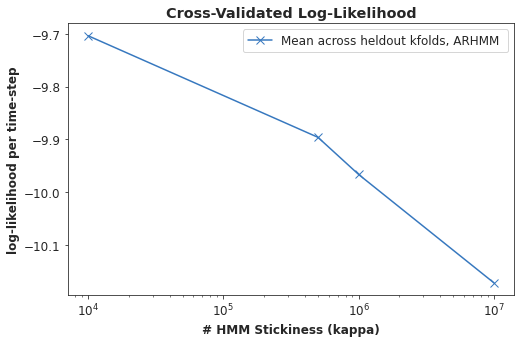

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

# ax.plot(Ks, np.mean(ll_training[:,:-1], axis=1), 'x-',color=usrplt.cc[0], markersize=8,label='Mean across training kfolds, ARHMM')
ax.plot(kappas, np.mean(ll_heldout[:,:-1], axis=1), 'x-',color=usrplt.cc[0], markersize=8,label='Mean across heldout kfolds, ARHMM ') 

# ax.plot(Ks_recurrent, np.mean(ll_training_recurrent[:,:-1], axis=1), 'o-',color=usrplt.cc[0], markersize=8,label='Mean across training kfolds, recurrent-ARHMM')
# ax.plot(Ks_recurrent, np.nanmean(ll_heldout_recurrent[:,:-1], axis=1), 'o-',color=usrplt.cc[1], markersize=8,label='Mean across heldout kfolds, recurrent-ARHMM ')    
ax.set_ylabel('log-likelihood per time-step')
ax.set_xlabel('# HMM Stickiness (kappa)')
ax.set_xticks(kappas)
ax.set_xscale('log')
ax.legend()

ax.set_title('Cross-Validated Log-Likelihood')
# plt.savefig('./plots/ARHMM_xvalidation_kappa.png')

In [69]:
K = 12
for ii, kappa in enumerate(kappas):
    print('\n{}:'.format(kappa),end='\t')
    KDir = os.path.join(BaseDir,'Kappa_{:.0e}'.format(kappa))
    
    #Load MAP sequence results
    fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
    trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

    #Create temporary ARHMM for plotting functions 
    arhmm = ssm.HMM(K, 6, observations='autoregressive',transitions='standard')
    arhmm.init_state_distn.params = arhmm_params['init_state_distn']['P0']
    arhmm.transitions.params = arhmm_params['transitions']['log_Ps']
    arhmm.observations.As = arhmm_params['observations']['As']
    arhmm.observations.bs = arhmm_params['observations']['bs']

    state_duration_list, state_startend_list, mean_state_durations, state_usage = util.get_state_durations(trMAPs, trMasks, K)

    ## Plot example trajectories of actual trajectories for each state
    usrplt.plot_example_trajectories(state_duration_list,state_startend_list,mean_state_durations, data_list, arhmm,longest=False,
                                    SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_varying-length_ARHMM_K-12_Kappa-{:0e}.pdf'.format(kappa))
    
    ## Plot example trajectories simulated from the model for each state
    usrplt.plot_example_trajectories(state_duration_list,state_startend_list,mean_state_durations,data_list, arhmm,longest=False, simulated=True,
                                SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_simulated_varying-length_ARHMM_K-12_Kappa-{:0e}.pdf'.format(kappa))


10000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



500000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



1000000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



10000000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [21]:
arhmm = ssm.HMM(K, 6, observations='autoregressive',transitions='standard')
arhmm.init_state_distn.params = arhmm_params['init_state_distn']['P0']
arhmm.transitions.params = arhmm_params['transitions']['log_Ps']
arhmm.observations.As = arhmm_params['observations']['As']
arhmm.observations.bs = arhmm_params['observations']['bs']

In [51]:
state_duration_list, state_startend_list, mean_state_durations, state_usage = util.get_state_durations(trMAPs, trMasks, K)

In [64]:
75*1E3/60

1250.0

In [68]:
## Plot example trajectories of actual trajectories for each state
usrplt.plot_example_trajectories(state_duration_list,state_startend_list,mean_state_durations, data_list, arhmm,longest=False,
                                SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_varying-length_ARHMM_K-12_Kappa-{:0e}.pdf'.format(kappa))

usrplt.plot_example_trajectories(state_duration_list,state_startend_list,mean_state_durations,data_list, arhmm,longest=False, simulated=True,
                                SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_simulated_varying-length_ARHMM_K-12_Kappa-{:0e}.pdf'.format(kappa))

In [25]:
nTrials = len(data_list)

# Calculate the max state duration for each state on each trial
state_durations_max = np.zeros((nTrials,K))
for iTrial, sd_trial in enumerate(state_duration_list):
    for iState, sd in enumerate(sd_trial[:-1]):
        if len(sd) == 0:
            state_durations_max[iTrial,iState] = 0
        else:
            state_durations_max[iTrial,iState] = np.median(sd)

In [18]:
nSeg = len(state_durations_max[:,iState])
indy = np.random.randint(0,nSeg)

In [30]:
np.argsort(state_durations_max[:,0],axis=0)[::-1]

array([3368, 3312, 3602, ..., 1944, 1947,    0])

In [86]:
data_df = pd.read_hdf('./data/jumping_data_102220.h5')
nTrials = len(data_df)
    
#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8
dsf = 3
#Loop over trials and reformat data for ARHMM
data_list_ds = []; mask_list_ds = []
data_list = []; mask_list = []
for iTrial in range(nTrials):
    #Get coordinates of Take-Off platform
    xc = np.nanmean(data_df.loc[iTrial]['Side TakeFL x'])
    yc = np.nanmean(data_df.loc[iTrial]['Side TakeFL y'])
    
    xy_list = []; ll_list = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        x = data_df.loc[iTrial]['Side {} x'.format(ptstr)]
        y = data_df.loc[iTrial]['Side {} y'.format(ptstr)]
        llhood = data_df.loc[iTrial]['Side {} likelihood'.format(ptstr)]
        
        #Coordinates relative to take-off platform
        xy_list.append((x-xc,y-yc))
        
        #Create mask for points that have a confidence lower than the given threshold
        mask = llhood > confidence_threshold
        ll_list.append((mask,mask))
    
    tmp = np.vstack(xy_list)[:,2:-2].T; data_list_ds.append(tmp[:-1:dsf,:]); data_list.append(tmp)
    tmp = np.vstack(ll_list)[:,2:-2].T; mask_list_ds.append(tmp[:-1:dsf,:]); mask_list.append(tmp)
#     pdb.set_trace()



In [103]:
BaseDir = './results/ARHMM/Side_NEE-all_mice-2020-11-10_1857/'
#Plot things for lag=2 kappa runs
kappas = np.array([1E3,1E4,1E5,1E6,1E7])
K = 10
for ii, kappa in enumerate(kappas):
    print('\n{}:'.format(kappa),end='\t')
    KDir = os.path.join(BaseDir,'Kappa_{:.0e}'.format(kappa))

    #Load MAP sequence results
    fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
    trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)
    
    #Create temporary ARHMM for plotting functions 
    arhmm = ssm.HMM(K, 6, observations='autoregressive',transitions='sticky',observation_kwargs={'lags':2},transition_kwargs={'kappa':kappa})
    arhmm.init_state_distn.params = arhmm_params['init_state_distn']['P0']
    arhmm.transitions.params = arhmm_params['transitions']['log_Ps']
    arhmm.observations.As = arhmm_params['observations']['As']
    arhmm.observations.bs = arhmm_params['observations']['bs']
        
    
    ## Calculate & plot state duration and state usage 
    state_duration_list, state_startend_list, mean_state_durations, state_usage = util.get_state_durations(trMAPs, trMasks, K)
    fname_sffx = 'stick_autoregressive-HMM_K-10_Lag-2_Kappa_{:.0e}'.format(kappa)
    
#     pdb.set_trace()
#     #Plot dynamics of latent states
#     usrplt.plot_dynamics_2d(arhmm,SAVEFIG=True,PlotDir=KDir,fname='AR-streamplots_{}.pdf'.format(fname_sffx))

#     ## Plot the actual AR matrices, with their corresponding fixed point
#     usrplt.plot_AR_matrices(arhmm,SAVEFIG=True,PlotDir=KDir,fname='AR-matrices_{}.pdf'.format(fname_sffx))

#     ## Plot example trajectories of actual trajectories for each state
#     usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, longest=True,
#                                     SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_longest-trials_{}.pdf'.format(fname_sffx))

#     ## Plot example trajectories of actual trajectories for each state
#     usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, longest=False,
#                                     SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_varying-length_{}.pdf'.format(fname_sffx))

    ## Plot example trajectories simulated from the model for each state
    usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, simulated=True,
                                    SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_simulated_longest-trials_{}.pdf'.format(fname_sffx))

    ## Plot example trajectories simulated from the model for each state
    usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, longest=False, simulated=True,
                                        SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_simulated_varying-length_{}.pdf'.format(fname_sffx))
    
    pdb.set_trace()
    



1000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



10000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



100000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



1000000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



10000000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [96]:
opt['K']

10

In [102]:
fname_sffx = 'stick_autoregressive-HMM_K-10_Lag-2_Kappa_{:.0e}'.format(kappa)
## Plot example trajectories of actual trajectories for each state
usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, longest=True,
                                SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_longest-trials_{}.pdf'.format(fname_sffx))

In [100]:
pdb.pm()

> /home/dwyrick/projects/jumping_behavior/plotting.py(524)plot_example_trajectories()
    522                 ax.plot(data[slice(iS,iE),2*iPt],data[slice(iS,iE),2*iPt+1],'-k',alpha=0.5)
    523 
--> 524                 ax.plot(data[iS,2*iPt],data[iS,2*iPt+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)#color=usrplt.cc[iState])
    525                 ax.plot(data[iE,2*iPt],data[iE,2*iPt+1],'o',color=cc[iState],markersize=6,markeredgecolor='k',markeredgewidth=1)
    526                 ax.plot(0,0,'+k',ms=15)



ipdb>  data.shape


(166, 6)


ipdb>  iS


205


ipdb>  q


In [ ]:
## Plot example trajectories of actual trajectories for each state
usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, longest=False,
                                SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_varying-length_{}.pdf'.format(fname_sffx))

In [83]:
A = arhmm.observations.As[0]# = arhmm_params['observations']['As']
b = arhmm.observations.bs[0]# = arhmm_params['observations']['bs']

In [ ]:
xstar = np.matmul(np.linalg.inv(np.tile(np.eye(6),2)-A),b)